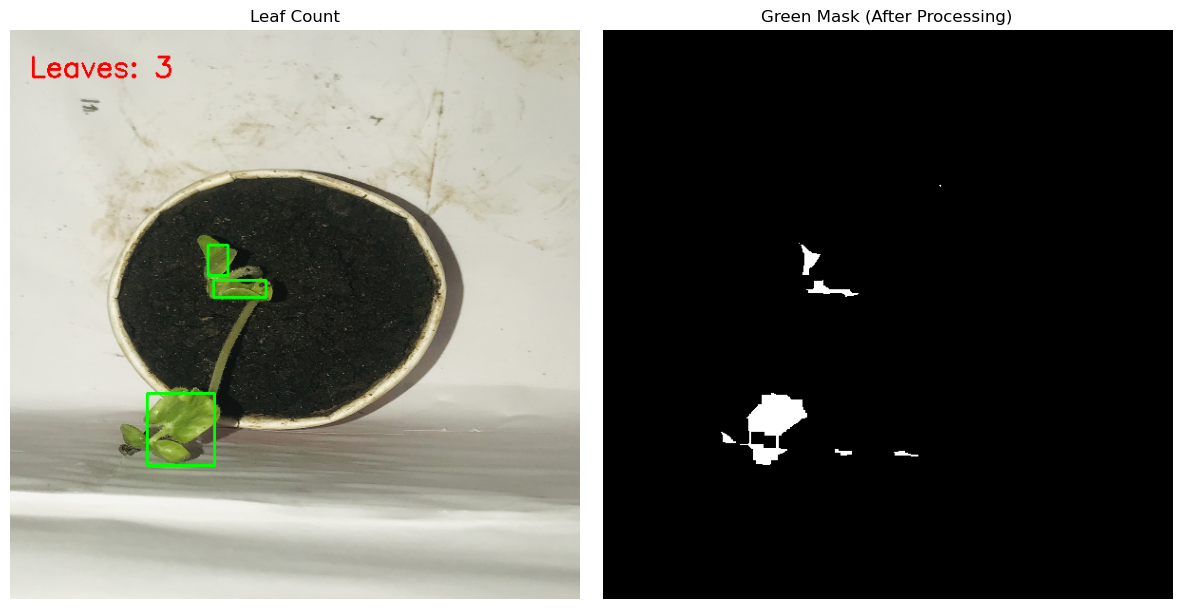

Total Leaves Counted: 3


3

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def count_leaves(image_path, min_contour_area=100):
    # Load image
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Could not load image from path: {image_path}")
        return

    image = cv2.resize(image, (600, 600))  # Resize for consistency

    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define refined green color range
    lower_green = np.array([20, 40, 40])
    upper_green = np.array([85, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Define kernel and apply erosion and closing
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=3)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=3)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

    leaf_count = len(valid_contours)

    # Draw contours
    annotated_image = image.copy()
    for cnt in valid_contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(annotated_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display leaf count
    cv2.putText(annotated_image, f'Leaves: {leaf_count}', (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # Convert BGR to RGB for displaying with matplotlib
    annotated_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

    # Show images using matplotlib
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(annotated_rgb)
    plt.title("Leaf Count")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Green Mask (After Processing)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print(f'Total Leaves Counted: {leaf_count}')
    return leaf_count

# Set image path and parameters
image_path = r"C:\Users\MALINGA\Desktop\Images\Plant_Images\Day8_Evening\Health\Plant1_Day8_Evening_Top.jpg"
min_area = 150

count_leaves(image_path, min_contour_area=min_area)
